# Audio features

### Load and display

In [14]:
import librosa
import IPython.display as ipd

In [ ]:
# path = "/home/kyogren/THESIS/Speaker_Verification_Final/demonstration/data/tdsv/enrollment_audio.wav"
# path = "/home/kyogren/THESIS/Speaker_Verification_Final/real_data_test/test1.wav"

path = "/home/kyogren/THESIS/Speaker_Verification_Final/real_data_test/dat2.m4a"
utter, _ =  librosa.load(path, sr=16000)

utter_trim, _ = librosa.effects.trim(utter, top_db=30)
duration = len(utter_trim)/16000
utter_strech = librosa.effects.time_stretch(utter_trim, rate=duration/1)
print(utter.shape, utter_trim.shape, utter_strech.shape)
ipd.Audio(utter, rate=16000)
# ipd.Audio(utter_trim, rate=16000)
# ipd.Audio(utter_strech, rate=16000)

### Draw on time domain

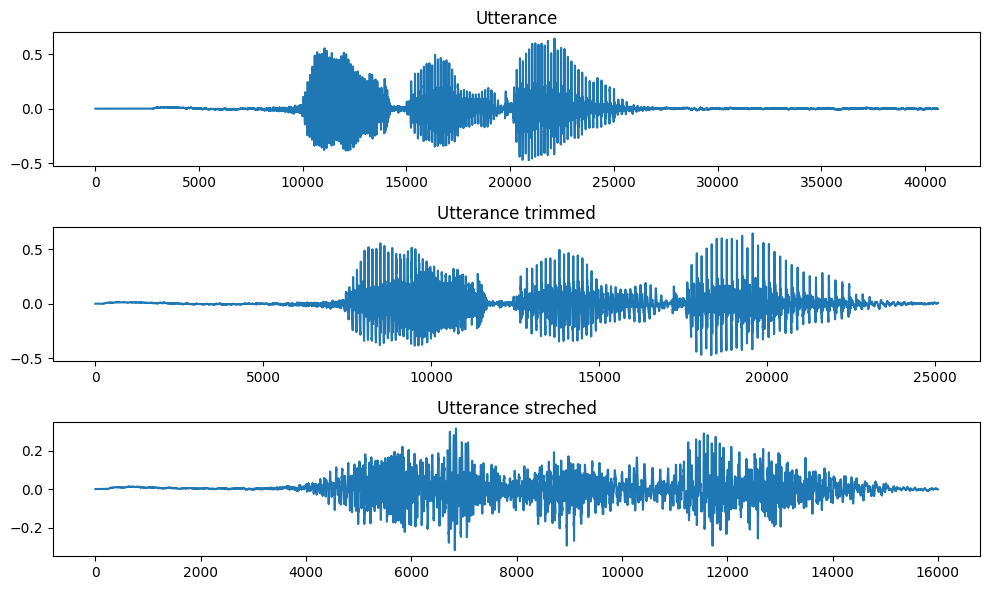

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(utter)
plt.title('Utterance')

plt.subplot(3, 1, 2)
plt.plot(utter_trim)
plt.title('Utterance trimmed')

plt.subplot(3, 1, 3)
plt.title('Utterance streched')
plt.plot(utter_strech)

plt.tight_layout()

### Draw on time-frequency domain

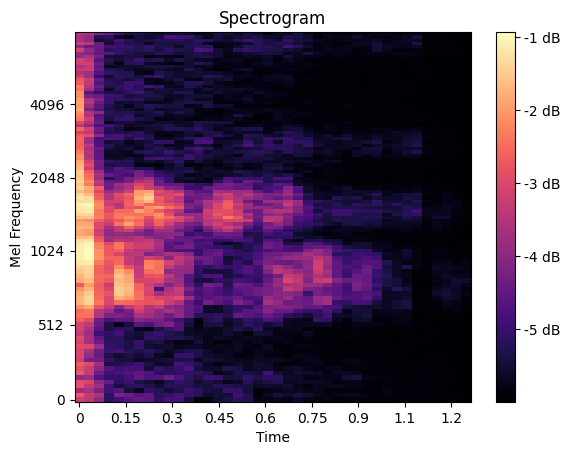

In [11]:
from utils import STFT_mel_audio_data
from parse_config import config
import matplotlib.pyplot as plt

data_config = config.data.TD_SV_data

S = STFT_mel_audio_data(data_config, utter_strech)

librosa.display.specshow(S, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.title('Spectrogram')
plt.show()


### Voice recorder

In [5]:
import pyaudio
import wave
import tkinter as tk
import pyaudio
import wave

# Set the audio parameters
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "../real_data_test/recording3.wav"

def start_recording():
    # Initialize the PyAudio object
    audio = pyaudio.PyAudio()

    # Open the audio stream
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        frames_per_buffer=CHUNK)

    print("Recording started...")

    # Create an empty list to store the audio frames
    frames = []

    # Record audio for the specified duration
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Recording finished.")

    # Stop and close the audio stream
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Save the recorded audio as a .wav file
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    print("Audio saved as", WAVE_OUTPUT_FILENAME)

# Create the GUI window
window = tk.Tk()
window.title("Audio Recorder")

# Create a button to start recording
start_button = tk.Button(window, text="Start Recording", command=start_recording)
start_button.pack()

# Run the GUI event loop
window.mainloop()



ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave


Recording started...
Recording finished.
Audio saved as ../real_data_test/recording3.wav


# Test new data with Trainned model

## Libraries

In [1]:
import torch
import librosa
import numpy as np
import torch.nn.functional as F
from utils import audio_arugment
from parse_config import config
from model_network import SpeechEmbedder

## Utils

In [52]:
def STFT_mel_audio_data(data_config, raw_utter):
    S = librosa.stft(raw_utter, n_fft=data_config.nfft, 
                     hop_length=int(data_config.hop * data_config.sr),
                     win_length=int(data_config.window * data_config.sr))
    S = np.abs(S) ** 2
    mel_basis = librosa.filters.mel(sr=data_config.sr, n_fft=data_config.nfft, n_mels=data_config.nmels)
    S = np.log10(np.dot(mel_basis, S) + 1e-6).T
    assert S.shape[0] >= data_config.frame, f"can't generate {data_config.frame} frames."
    return S # -> shape [num_frame, data_config.nmel]

def pre_preprocess_tdsv(data_config, utter_path):
    utter, _ =  librosa.load(utter_path, sr=data_config.sr)
    utter_trim, _ = librosa.effects.trim(utter, top_db=30)
    duration = len(utter_trim)/data_config.sr
    utter_strech = librosa.effects.time_stretch(utter_trim, rate=duration/1)
    S = STFT_mel_audio_data(data_config, utter_strech)
    S = S[:data_config.frame, :]
    return S

def pre_preprocess_tisv(data_config, utter_path):
    utter_min_len = data_config.sr * data_config.duration
    utter, _ =  librosa.load(utter_path, sr=data_config.sr)
    intervals = librosa.effects.split(utter, top_db=30)
    utter_spec = []
    
    for interval in intervals:
        if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
            utter_part = utter[interval[0]:interval[1]] 
            S = STFT_mel_audio_data(data_config, utter_part)
            utter_spec.append(S[:data_config.frame])
            utter_spec.append(S[-data_config.frame:])
    return np.array(utter_spec)

## TDSV

In [9]:
def test_tdsv(model_path, enrollment_path, evaluation_path):    
    data_config = config.data.TD_SV_data

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    speech_embedder = SpeechEmbedder().to(device)
    speech_embedder.load_state_dict(torch.load(model_path)['speech_embedder'])
    speech_embedder.eval()

    enrollment_utterance = pre_preprocess_tdsv(data_config, enrollment_path)
    evaluation_utterance = pre_preprocess_tdsv(data_config, evaluation_path)
    
    enrollment_utterance = torch.from_numpy(enrollment_utterance).to(device)
    evaluation_utterance = torch.from_numpy(evaluation_utterance).to(device)

    print(enrollment_utterance.shape, evaluation_utterance.shape)

    frames, nmels = 80, 40
    enrollment_utterance = enrollment_utterance.reshape(1, frames, nmels)
    evaluation_utterance = evaluation_utterance.reshape(1, frames, nmels)
    print(enrollment_utterance.shape, evaluation_utterance.shape)

    enrollment_embedding = speech_embedder(enrollment_utterance)
    evaluation_embedding = speech_embedder(evaluation_utterance)
    print(enrollment_embedding.shape, evaluation_embedding.shape)
    
    # np.savetxt('enrollment_embedding.txt', enrollment_embedding.cpu().detach().numpy())
    # np.savetxt('evaluation_embedding.txt', evaluation_embedding.cpu().detach().numpy())

    similarity = F.cosine_similarity(enrollment_embedding, evaluation_embedding)
    similarity = similarity.cpu().detach().numpy()[0]
    return similarity

model_path = "../model_saving/30_4/tdsv/tdsv_30_4_3_10_2000.model"
enrollment_path = "/home/kyogren/THESIS/Speaker_Verification_Final/real_data_test/dat.m4a"
evaluation_path = "/home/kyogren/THESIS/Speaker_Verification_Final/real_data_test/quan.m4a"

result = test_tdsv(model_path, enrollment_path, evaluation_path)
result = 0 if result < 0 else result
print(f"similarity: {result:.4f}")

RuntimeError: Error(s) in loading state_dict for SpeechEmbedder:
	size mismatch for LSTM_stack.weight_ih_l0: copying a param with shape torch.Size([512, 40]) from checkpoint, the shape in current model is torch.Size([3072, 40]).
	size mismatch for LSTM_stack.weight_hh_l0: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for LSTM_stack.bias_ih_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for LSTM_stack.bias_hh_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for LSTM_stack.weight_ih_l1: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for LSTM_stack.weight_hh_l1: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for LSTM_stack.bias_ih_l1: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for LSTM_stack.bias_hh_l1: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for LSTM_stack.weight_ih_l2: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for LSTM_stack.weight_hh_l2: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for LSTM_stack.bias_ih_l2: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for LSTM_stack.bias_hh_l2: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for projection.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 768]).
	size mismatch for projection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).

In [21]:
import numpy as np

enroll_path = '../src/enrollment_embedding.txt'
eva_path = '../src/evaluation_embedding.txt'

enroll = np.loadtxt(enroll_path)
eva = np.loadtxt(eva_path)

enroll_tensor = torch.from_numpy(enroll)
eva_tensor = torch.from_numpy(eva)

enroll_tensor = enroll_tensor.reshape(1, enroll_tensor.shape[0])
eva_tensor = eva_tensor.reshape(1, eva_tensor.shape[0])

similarity = F.cosine_similarity(enroll_tensor, eva_tensor)
similarity = similarity.cpu().detach().numpy()[0]
print(f"similarity: {similarity:.4f}")

similarity: 0.7391


## TISV

In [71]:
def test_tisv(model_path, enrollment_path, evaluation_path):    
    
    data_config = config.data.TI_SV_data

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    speech_embedder = SpeechEmbedder().to(device)
    speech_embedder.load_state_dict(torch.load(model_path)['speech_embedder'])
    speech_embedder.eval()

    enrollment_utterance = pre_preprocess_tisv(data_config, enrollment_path)
    evaluation_utterance = pre_preprocess_tisv(data_config, evaluation_path)
    
    enrollment_utterance = torch.from_numpy(enrollment_utterance).to(device)
    evaluation_utterance = torch.from_numpy(evaluation_utterance).to(device)

    enrollment_embedding = speech_embedder(enrollment_utterance)
    evaluation_embedding = speech_embedder(evaluation_utterance)
    print(enrollment_embedding.shape, evaluation_embedding.shape)
    
    similarity = F.cosine_similarity(enrollment_embedding, evaluation_embedding)
    similarity = similarity.cpu().detach().numpy()[0]
    return similarity

model_path = "../model_saving/6_5/tisv/final_model.model"
enrollment_path = "../real_data_test/tisv_quan_test3.wav"
evaluation_path = "../datasets/TIMIT/data/TRAIN/DR3/MADC0/SX377.WAV.wav"

result = test_tisv(model_path, enrollment_path, evaluation_path)
# result = 0 if result < 0 else result

print(f"similarity: {result:.4f}")

torch.Size([2, 256]) torch.Size([2, 256])
similarity: -0.1450


In [ ]:
test_loader = DataLoader(test_set, batch_size=test_config.N, shuffle=False, drop_last=True)

# Draw loss

## TDSV

18000


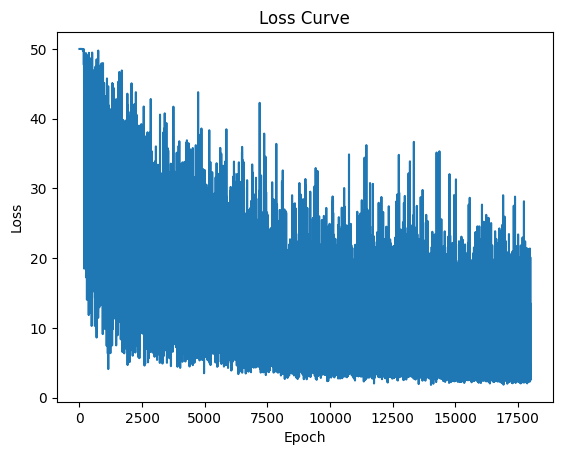

In [7]:
import torch
import matplotlib.pyplot as plt

file_path = "/home/kyogren/THESIS/Speaker_Verification_Final/log/loss/tdsv/loss.loss"
loss_data = torch.load(file_path)
lossdata = loss_data['loss']
print(len(lossdata))

plt.plot(lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [45]:
EER_log_tdsv = torch.load('/home/kyogren/THESIS/Speaker_Verification_Final/log/EER/tdsv/EER.eer')
print("Avg EER for TD-SV is {}".format(EER_log_tdsv["avg_EER_log"][-1]))

Avg EER for TD-SV is 0.025387236976559792


## TISV

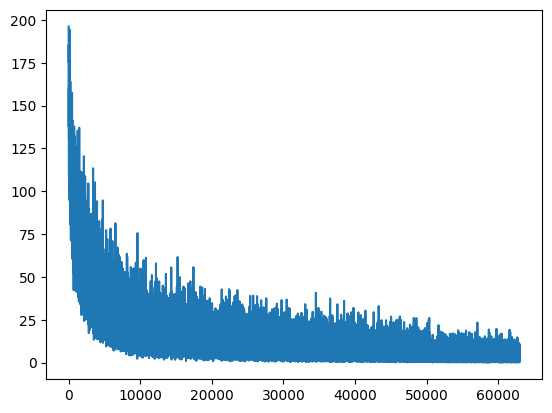

In [8]:
file_path = "/home/kyogren/THESIS/Speaker_Verification_Final/model_saving/30_4/tisv/loss_tisv_30_4_9_10_1000.loss"
loss_data = torch.load(file_path)
lossdata = loss_data['loss']

plt.plot(lossdata)

In [9]:
EER_log_tdsv = torch.load('/home/kyogren/THESIS/Speaker_Verification_Final/model_saving/30_4/tisv/EER.eer')
print("Avg EER for TI-SV is {}".format(EER_log_tdsv["avg_EER_log"][-1]))

Avg EER for TD-SV is 0.11734017122426957
